In [1]:
from __future__ import print_function
from __future__ import absolute_import

import os, socket
if socket.gethostname()=="euler":
    os.environ["CUDA_VISIBLE_DEVICES"]="7"

import keras
import sys
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Dense, Dropout, Reshape, Permute
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.layers.recurrent import GRU
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model

sys.path.insert(0, './deep-learning-models')
from audio_conv_utils import decode_predictions, preprocess_input

TH_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.3/music_tagger_crnn_weights_tf_kernels_th_dim_ordering.h5'
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.3/music_tagger_crnn_weights_tf_kernels_tf_dim_ordering.h5'

#K._LEARNING_PHASE = tf.constant(False)
#K.LEARNING_PHASE = tf.constant(False)
#K.LEARNING_PHASE = "HELLO"
#K.set_learning_phase(1)

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
from __future__ import print_function

import os
import sys
import random
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, merge
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers.core import Masking
from keras.layers.recurrent import LSTM
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, CSVLogger
from keras.optimizers import rmsprop, SGD, Adam
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

sys.path.insert(0, './deep-learning-models')
from music_tagger_crnn import MusicTaggerCRNN
from audio_conv_utils import preprocess_input, decode_predictions

from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import pylab as P

import socket
if socket.gethostname()=="euler":
    os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [3]:
def create_run_name(params):
    k_v_names = []
    for k,v in params.items():
        k_v_names.append((k,v))
        
    k_v_names.sort(key=lambda x: x[0])
    out_str = ""
    for k,v in k_v_names:
        out_str += k + "_" + str(v).replace('.', '-') + "|"
    return out_str[:-1]

In [4]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    dist = K.maximum(y_pred, 0)
    return K.mean(y_true * K.square(dist) + (1 - y_true) * K.square(K.maximum(params['glob_margin'] - dist, 0)))

def custom_crossentropy(y_true, y_pred):
    # y_pred *is* distance
    dist = K.maximum(y_pred, 0)
    return K.mean(y_true * K.log(K.tanh(dist)) + (1 - y_true) * K.log(1 - K.tanh(dist)))

In [5]:
debug = False
test = False
load_model = False
params = {}
params['loss'] = 'custom_crossentropy'
params['optimizer'] = 'Adam'

run_name = create_run_name(params)
run_name

'loss_custom_crossentropy|optimizer_Adam'

In [6]:
# load all necessary files
valids = pickle.load(open("valids.pkl", "rb"))
pairs = pickle.load(open("pairs.pkl", "rb"))
msd_to_info = pickle.load(open("msd_to_info.pkl", "rb"))

In [7]:
print("valids size:", sys.getsizeof(valids)/1000000, "mB")
print("pairs size:", sys.getsizeof(pairs)/1000000, "mB")
print("msd_to_info size:", sys.getsizeof(msd_to_info)/1000000, "mB")

valids size: 2.097376 mB
pairs size: 2.853112 mB
msd_to_info size: 1.57296 mB


[ 0.445961    0.688843    0.99463728 ...,  0.9737456   0.9810458   0.9816389 ]


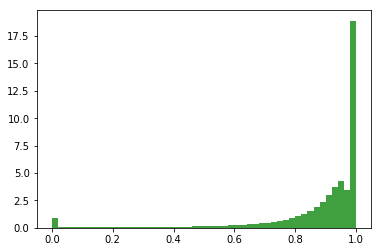

In [8]:
# most of the similarities lie close to zero
sims = np.asarray([float(x[2]) for x in pairs])
print(sims)
#n, bins, patches = plt.hist(sims, 50, normed=1, facecolor='green', alpha=0.75)
n, bins, patches = P.hist(sims, 50, normed=1, histtype='stepfilled')
P.setp(patches, 'facecolor', 'g', 'alpha', 0.75)

P.show()

# 0 means absolutely the same, 1.0 means absolutely dissimilar

In [9]:
zeros = 0
ones = 0
for x in sims:
    if x < 1e-2:
        zeros += 1
    elif x > 1 - 1e-2:
        ones += 1
print("zeros:", zeros)
print("ones:", ones)

zeros: 5648
ones: 114098


In [10]:
msd_to_info['TRNUDQL128E0783E5C']

('SHSDataset/mp3/3344 - Bali_Ha_i/18044.clip.mp3',
 "Bali Ha'i",
 'SODXUGX12A6310DBED',
 'On The Moon',
 'ARITVH41187B9A5FE4',
 'e670db87-f910-4286-bfc6-d7ddd0b0bfbd',
 'Peter Cincotti',
 239.25506,
 0.750112125537,
 0.433159162811,
 2004,
 18044,
 59758,
 28094,
 (('easy listening', 50.0), ('00s', 25.0), ('jazz', 100.0)))

In [11]:
# test the music tagger model for sanity
if test == True:
    model = MusicTaggerCRNN(weights='msd')

    shuffled_valids = list(valids)
    random.shuffle(shuffled_valids)

    count = 0
    for song in shuffled_valids:    
        audio_path = '/mnt/kahuna/MSD_audio/' + msd_to_info[song][0]
        tags = msd_to_info[song][-1]
        if type(tags) == type(0) or len(tags) == 0:
            # no tags
            tags = None
            continue
        melgram = preprocess_input(audio_path)
        melgrams = np.expand_dims(melgram, axis=0)

        preds = model.predict(melgrams)
        print(msd_to_info[song][1], msd_to_info[song][3], msd_to_info[song][6])
        print('Predicted:')
        print(decode_predictions(preds))
        print('Actual:')
        if tags is not None:
            print(sorted(list(tags),key=lambda x: x[1],reverse=True))
        else:
            print("N/A")
        print('-'*20)
        count += 1
        if count >= 20:
            break

In [12]:
pairs = np.asarray(pairs)
indices = np.arange(pairs.shape[0], dtype="int32")
np.random.shuffle(indices)
pairs = pairs[indices]
split_pt = int(len(pairs)/7)
pairs_train = pairs[:split_pt]
pairs_test = pairs[split_pt:]

In [13]:
# some useful functions:
def euc_dist(x):
    'Merge function: euclidean_distance(u,v)'
    print(x[0].get_shape(), x[1].get_shape())
    diff = tf.subtract(x[0], x[1])
    diff_sq = tf.square(diff)
    #output = tf.reduce_sum(diff_sq, 2)
    output_sq = tf.reduce_sum(diff_sq, 1)
    #output = tf.sqrt(output_sq)
    output = tf.reshape(output, (-1,1))
    print("output.get_shape()", output.get_shape())
    return output

def euc_dist_shape(input_shape):
    'Merge output shape'
    shape = list(input_shape)
    #outshape = (shape[0][0],shape[0][1])
    outshape = (shape[0][0],1)
    print("outshape", outshape)
    return tuple(outshape)

def euc(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def siamese_accuracy(y_true, y_pred):
    margin = tf.constant([params['glob_margin']])
    zero = tf.constant([0.0])
    return K.mean(K.equal(np.abs(1 - y_true), K.cast(K.greater_equal(y_pred, margin), 'float32')))

# add callback for learning rate
def step_decay(epoch):
    initial_lrate = 1e-4
    drop = 0.1
    epochs_drop = 150.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)

csv_logger = CSVLogger(run_name + '.log')
checkpointer = ModelCheckpoint(filepath='./' + run_name + '.hdf5', verbose=1, save_best_only=True)
optimizer = rmsprop(lr=0.0)

In [14]:
if load_model:
    model = keras.models.load_model(run_name, custom_objects={params['loss'][0]: params['loss'][1]})
else:
    # now build actual model

    # Determine proper input shape
    if K.image_dim_ordering() == 'th':
        input_shape = (1, 96, 1366)
    else:
        input_shape = (96, 1366, 1)

    melgram_input1 = Input(shape=input_shape)
    melgram_input2 = Input(shape=input_shape)

    # Determine input axis
    if K.image_dim_ordering() == 'th':
        channel_axis = 1
        freq_axis = 2
        time_axis = 3
    else:
        channel_axis = 3
        freq_axis = 1
        time_axis = 2

    layers = []
    # Input block
    layers.append(ZeroPadding2D(padding=(0, 37)))
    layers.append(BatchNormalization(axis=time_axis, name='bn_0_freq'))

    # Conv block 1
    layers.append(Convolution2D(64, 3, 3, border_mode='same', name='conv1')) 
    layers.append(BatchNormalization(axis=channel_axis, mode=0, name='bn1')) 
    layers.append(ELU()) 
    layers.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1')) 

    # Conv block 2
    layers.append(Convolution2D(128, 3, 3, border_mode='same', name='conv2')) 
    layers.append(BatchNormalization(axis=channel_axis, mode=0, name='bn2')) 
    layers.append(ELU()) 
    layers.append(MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name='pool2')) 

    # Conv block 3
    layers.append(Convolution2D(128, 3, 3, border_mode='same', name='conv3')) 
    layers.append(BatchNormalization(axis=channel_axis, mode=0, name='bn3')) 
    layers.append(ELU()) 
    layers.append(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='pool3')) 

    # Conv block 4
    layers.append(Convolution2D(128, 3, 3, border_mode='same', name='conv4'))
    layers.append(BatchNormalization(axis=channel_axis, mode=0, name='bn4'))
    layers.append(ELU())
    layers.append(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='pool4'))

    # reshaping
    layers.append(Reshape((15, 128)))

    # GRU block 1, 2, output
    layers.append(GRU(32, return_sequences=True, name='gru1'))
    layers.append(GRU(32, return_sequences=False, name='gru2'))

    x1 = melgram_input1
    x2 = melgram_input2

    for l in layers:
        x1 = l(x1)
        x2 = l(x2)

    output = merge([x1, x2], mode=euc, output_shape=euc_dist_shape)

    model = Model(input=[melgram_input1, melgram_input2], output=[output])

    # Load weights
    if K.image_dim_ordering() == 'tf':
        weights_path = get_file('music_tagger_crnn_weights_tf_kernels_tf_dim_ordering.h5',
                                TF_WEIGHTS_PATH,
                                cache_subdir='models')
    else:
        weights_path = get_file('music_tagger_crnn_weights_tf_kernels_th_dim_ordering.h5',
                                TH_WEIGHTS_PATH,
                                cache_subdir='models')
    model.load_weights(weights_path, by_name=True)
    if K.backend() == 'theano':
        convert_all_kernels_in_model(model)

    #sgd = SGD(lr=params['sgd_lr'], decay=0, momentum=0.9, nesterov=True)
    optimizer = Adam(lr=5e-3)

    #model.compile(optimizer=sgd, loss=contrastive_loss, metrics=['mean_squared_error'])
    #model.compile(optimizer=optimizer, loss=contrastive_loss, metrics=['mean_squared_error'])
    model.compile(optimizer=optimizer, loss=custom_crossentropy, metrics=['mean_squared_error'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", name="conv1")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=3, name="bn1")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", name="conv2")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=3, name="bn2")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", name="conv3")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `BatchNormalization` call to 

outshape (None, 1)


In [15]:
#K.set_value(optimizer.lr, .1)
#K.get_value(optimizer.lr)

In [16]:
def librosa_exists():
    try:
        __import__('librosa')
    except ImportError:
        return False
    else:
        return True
    
def preprocess_input(audio_path, dim_ordering='default'):
    '''Reads an audio file and outputs a Mel-spectrogram.
    '''
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    assert dim_ordering in {'tf', 'th'}

    if librosa_exists():
        import librosa
    else:
        raise RuntimeError('Librosa is required to process audio files.\n' +
                           'Install it via `pip install librosa` \nor visit ' +
                           'http://librosa.github.io/librosa/ for details.')

    # mel-spectrogram parameters
    SR = 12000
    N_FFT = 512
    N_MELS = 96
    HOP_LEN = 256
    DURA = 29.12
    
    try:
        src, sr = librosa.load(audio_path, sr=SR)
    except:
        print("ERROR!")
        raise
    n_sample = src.shape[0]
    n_sample_wanted = int(DURA * SR)

    # trim the signal at the center
    if n_sample < n_sample_wanted:  # if too short
        src = np.hstack((src, np.zeros((int(DURA * SR) - n_sample,))))
    elif n_sample > n_sample_wanted:  # if too long
        src = src[int((n_sample - n_sample_wanted) / 2):
                  int((n_sample + n_sample_wanted) / 2)]

    logam = librosa.logamplitude
    melgram = librosa.feature.melspectrogram
    x = logam(melgram(y=src, sr=SR, hop_length=HOP_LEN,
                      n_fft=N_FFT, n_mels=N_MELS) ** 2,
                      ref_power=1.0)
    #librosa.display.specshow(x, sr=SR, hop_length=HOP_LEN,
    #                  n_fft=N_FFT, n_mels=N_MELS)

    if dim_ordering == 'th':
        x = np.expand_dims(x, axis=0)
    elif dim_ordering == 'tf':
        x = np.expand_dims(x, axis=3)
    return x

In [17]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import librosa

def getMfcc(audio_path):
    SR = 12000
    SR = 12000
    N_FFT = 512
    N_MELS = 96
    HOP_LEN = 256
    DURA = 29.12
    #(rate,sig) = wav.read("AudioFile.wav")
    src, sr = librosa.load(audio_path, sr=SR)
    n_sample = src.shape[0]
    n_sample_wanted = int(DURA * SR)

    # trim the signal at the center
    if n_sample < n_sample_wanted:  # if too short
        src = np.hstack((src, np.zeros((int(DURA * SR) - n_sample,))))
    elif n_sample > n_sample_wanted:  # if too long
        src = src[int((n_sample - n_sample_wanted) / 2):
                  int((n_sample + n_sample_wanted) / 2)]
    #mfcc_feat = mfcc(sig,rate)
    mfcc_feat = mfcc(src,samplerate=sr,)

    print(mfcc_feat)
    plt.plot(mfcc_feat)
    plt.show()
    return mfcc_feat

In [18]:
def generate_samples(pairs, minibatch_size):
    n = len(pairs)
    tot = np.product((96,1366,1))
    tot_count = 0
    while 1:
        x_1_arr = np.empty((minibatch_size, 96, 1366, 1))
        x_2_arr = np.empty((minibatch_size, 96, 1366, 1))
        y_arr = np.empty((minibatch_size,))
        i = 0
        while i < minibatch_size:
            rand_num = random.randint(0,n-1)
            #print("generating", i+1, "out of", minibatch_size, "samples")
            x_1, x_2, y = pairs[rand_num]
            audio_path1 = '/mnt/kahuna/MSD_audio/' + msd_to_info[x_1][0]
            audio_path2 = '/mnt/kahuna/MSD_audio/' + msd_to_info[x_2][0]
            #getMfcc(audio_path1)
            try:
                melgram1 = preprocess_input(audio_path1)
                melgram2 = preprocess_input(audio_path2)
            except EOFError:
                print("EOF Error:", sys.exc_info()[0])
                print(audio_path1, "|", audio_path2)
                continue
            x_1_arr[i,:,:,:] = np.expand_dims(melgram1, axis=0)
            x_2_arr[i,:,:,:] = np.expand_dims(melgram2, axis=0)
            y_arr[i] = y
            #y_arr[i] = tot_count
            i += 1
            tot_count += 1
        yield(([x_1_arr, x_2_arr], y_arr))

count = 0
tf_false = tf.cast(tf.constant([0.0]), 'bool')
"""
for x, y in generate_samples(pairs_train, 1):
    x_1, x_2 = x
    # most of the similarities lie close to zero
    vals = x[0].flatten()
    #n, bins, patches = plt.hist(sims, 50, normed=1, facecolor='green', alpha=0.75)
    n, bins, patches = P.hist(vals, 50, normed=1, histtype='stepfilled')
    P.setp(patches, 'facecolor', 'g', 'alpha', 0.75)

    P.show()
    #print(x_1,x_2)
    #K.set_learning_phase(False)
    print(crnn_out1_f([x_1,x_2]))
    print(crnn_out2_f([x_1,x_2]))
    dist = model.predict([x_1, x_2])
    print(model.predict([x_1, x_2]))
    loss = contrastive_loss(y, dist)
    loss = K.eval(loss)
    print(loss)
    #print(lstm_out1_f([x_1,x_2]), lstm_out2_f([x_1,x_2]))
    count += 1
    if count > 0:
        break
"""

"\nfor x, y in generate_samples(pairs_train, 1):\n    x_1, x_2 = x\n    # most of the similarities lie close to zero\n    vals = x[0].flatten()\n    #n, bins, patches = plt.hist(sims, 50, normed=1, facecolor='green', alpha=0.75)\n    n, bins, patches = P.hist(vals, 50, normed=1, histtype='stepfilled')\n    P.setp(patches, 'facecolor', 'g', 'alpha', 0.75)\n\n    P.show()\n    #print(x_1,x_2)\n    #K.set_learning_phase(False)\n    print(crnn_out1_f([x_1,x_2]))\n    print(crnn_out2_f([x_1,x_2]))\n    dist = model.predict([x_1, x_2])\n    print(model.predict([x_1, x_2]))\n    loss = contrastive_loss(y, dist)\n    loss = K.eval(loss)\n    print(loss)\n    #print(lstm_out1_f([x_1,x_2]), lstm_out2_f([x_1,x_2]))\n    count += 1\n    if count > 0:\n        break\n"

In [19]:
if debug:
    # debug nans
    keep_looping = True
    count = 0
    for x, y in generate_samples(pairs_train, 1):
        #print("close:", [np.sum(np.isclose(x1,x2))/np.product(x1.shape) for x1,x2 in zip(x[0], x[1])])
        prev_input = [x,y]
        prev_weights2 = model.layers[-2].get_weights()
        prev_weights3 = model.layers[-3].get_weights()
        model.fit(x, y, batch_size=1, epochs=1, verbose=1)
        #print("loop num:", count, x)
        for w in model.layers[-2].get_weights():
            if np.sum(np.isnan(w)) > 0:
                keep_looping = False
                break
        if keep_looping == False:
            break
        for w in model.layers[-3].get_weights():
            if np.sum(np.isnan(w)) > 0:
                keep_looping = False
                break
        if keep_looping == False:
            break
        count += 1

In [20]:
if debug:
    prev_learning_phase = K.learning_phase()
    K.set_learning_phase(False)
    x, y = prev_input
    model.layers[-2].set_weights(prev_weights2)
    model.layers[-3].set_weights(prev_weights3)
    dist = model.predict(x)
    crnn_out1 = crnn_out1_f(x)
    crnn_out2 = crnn_out2_f(x)
    loss = contrastive_loss(y, dist)
    inputs = [x[0][0,:].reshape(1,96,1366,1),
              x[1][0,:].reshape(1,96,1366,1), # X
              [1], # sample weights
              #y[0].reshape(-1,1), # y
              np.asarray([[1]]).reshape(-1,1),
              0 # learning phase in TEST mode
    ]
    gradients1 = get_gradients(inputs)
    for w,g in zip(weights, gradients1):
        print('-'*20)
        w_e = K.eval(w)
        print(w_e)
        print(np.sum(np.isnan(w_e)))
        print('-'*10)
        print(g)
        print(np.sum(np.isnan(g)))
    print('-'*20)
    print(crnn_out1[0].shape, crnn_out2[0].shape)
    print(crnn_out1)
    print(crnn_out2)
    print("-"*20)
    print(end_grad[0].shape, end_grad[1].shape)
    print(end_grad)
    print(dist)
    print(K.eval(loss))

In [21]:
if debug:
    count = 0
    for x, y in generate_samples(pairs_train, 1):
        count += 1
        print(count)

In [ ]:
best_loss = float('inf')
count = 0
for train, test in zip(generate_samples(pairs_train, 32), generate_samples(pairs_test, 32)):
    x_tr, y_tr = train
    x_te, y_te = test
    ret = model.fit(x_tr, y_tr, batch_size=1, epochs=1, verbose=1, validation_data=(x_tr, y_tr), callbacks=[lrate])
    try:
        val_loss = np.mean(ret.history['val_loss'])
    except KeyError:
        print('uh oh, no val_loss')
        pass
    print("epoch:", count)
    if count % 10 == 0:
        print('saving model at epoch', count, '| loss:', val_loss)
        model.save(run_name)
    if not np.isnan(val_loss) and best_loss > val_loss:
        best_loss = val_loss
        print('saving best model with loss:', best_loss)
        model.save(run_name+'_best_'+str(best_loss))
    #if count % 150 == 0:
    #    K.set_value(sgd.lr, 0.1 * K.get_value(sgd.lr))
    count += 1

ERROR!
EOF Error: <class 'EOFError'>
/mnt/kahuna/MSD_audio/SHSDataset/mp3/5059 - Dance_Me_To_The_End_Of_Love/18028.clip.mp3 | /mnt/kahuna/MSD_audio/SHSDataset/mp3/999 - The_Look_Of_Love/277692.clip.mp3
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 3s - loss: -0.4412 - mean_squared_error: 1.4458 - val_loss: -0.5135 - val_mean_squared_error: 3.7960
epoch: 0
saving model at epoch 0 | loss: -0.513483554154
saving best model with loss: -0.513483554154
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 3s - loss: -0.3500 - mean_squared_error: 1.3633 - val_loss: -0.4671 - val_mean_squared_error: 4.2519
epoch: 1
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 3s - loss: -0.3750 - mean_squared_error: 2.1243 - val_loss: -0.3930 - val_mean_squared_error: 4.9550
epoch: 2
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [=============================

In [ ]:
print(dir(ret))
ret.validation_data

In [ ]:
print_every = 1 # print every n minibatches
minibatch_size = 2
number_of_batches = 100
hist = model.fit_generator(generate_samples(pairs_train, minibatch_size), steps_per_epoch=print_every, epochs=number_of_batches,
                   validation_data=generate_samples(pairs_test, minibatch_size), validation_steps=1,
                   callbacks=[lrate, csv_logger, checkpointer], verbose=1, 
                           max_q_size=1, workers=1)

In [ ]:
model.layers[-2].get_weights()